<a href="https://colab.research.google.com/github/GPhMorin/geneo/blob/main/examples/correlation_mds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation computation and visualization

This script computes pairwise relationship correlation of the probands from the **genea140** dataset and plots the individuals based on those correlations.

In [ ]:
!python --version

Python 3.10.12


The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the pairwise kinship coefficients.

In [23]:
%pip install scikit-bio https://github.com/GPhMorin/geneo/archive/main.zip

  Using cached https://github.com/GPhMorin/geneo/archive/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [24]:
import numpy as np
import pandas as pd
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import geneo as gen
from itertools import combinations
from math import factorial
from sklearn.impute import SimpleImputer

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> "A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [25]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [26]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140.iloc[:10, :]

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
5,302716,Saguenay
6,868572,Saguenay
7,717634,Saguenay
8,409808,Saguenay
9,718567,Saguenay


Now let's compute the pairwise kinship coefficients. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [27]:
phi = gen.phi(genea140)
phi.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,0.501290,0.000235,0.005807,0.005166,0.008142
218089,0.000235,0.500118,0.000271,0.000230,0.000230
219947,0.005807,0.000271,0.502834,0.006361,0.007380
288708,0.005166,0.000230,0.006361,0.502508,0.008097
288764,0.008142,0.000230,0.007380,0.008097,0.506433


The pairwise kinship coefficients are then transformed into correlations, where an individual with themself has a correlation of 1 and two unrelated individuals have a correlation of 0.

In [28]:
corr = phi.copy()
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i != j:
            corr.iloc[i, j] = corr.iloc[i, j] / (np.sqrt(phi.iloc[i, i]) * np.sqrt(phi.iloc[j, j]))
for i in range(corr.shape[0]):
    corr.iloc[i, i] = 1
corr.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,1.000000,0.000470,0.011566,0.010293,0.016159
218089,0.000470,1.000000,0.000540,0.000459,0.000457
219947,0.011566,0.000540,1.000000,0.012654,0.014624
288708,0.010293,0.000459,0.012654,1.000000,0.016052
288764,0.016159,0.000457,0.014624,0.016052,1.000000


In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [29]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


Let's embed the data into two-dimensional space.

In [30]:
results = pcoa(1 - corr)
emb = results.samples.to_numpy()
emb[:10, :]

array([[-5.18105606e-02,  9.52585285e-02, -1.27600190e-02, ...,
         2.65104218e-03, -1.20825912e-03, -0.00000000e+00],
       [ 3.56952569e-03, -5.88882471e-02,  2.20050785e-02, ...,
         2.17729879e-03, -3.61796461e-04, -0.00000000e+00],
       [-8.67232735e-02,  6.55693182e-02, -2.77563198e-03, ...,
         2.57800453e-03,  9.40230469e-04, -0.00000000e+00],
       ...,
       [-1.19595318e-01,  1.09163640e-01, -6.96378383e-03, ...,
         1.49170941e-04,  1.65735317e-05, -0.00000000e+00],
       [-1.36675030e-01,  1.29893827e-01, -9.70484849e-03, ...,
         7.28436338e-04,  3.22599286e-04, -0.00000000e+00],
       [-1.01432945e-01,  8.40463200e-02, -1.05685540e-03, ...,
         1.61547503e-04, -1.08776409e-04, -0.00000000e+00]])

In [31]:
ratios = results.proportion_explained
ratios

,0
PC1,0.013699
PC2,0.011331
PC3,0.008993
PC4,0.008531
PC5,0.008257
...,...
PC136,0.006397
PC137,0.006293
PC138,0.006169
PC139,0.005533


Probands are identified using the `gen.pro` function.

In [32]:
pro = gen.pro(genea140)
pro[:10]

[217891,
 218089,
 219947,
 288708,
 288764,
 302710,
 302711,
 302716,
 302717,
 302718]

For each proband, we obtain their corresponding population from the **pop140** dataset.

In [33]:
pops = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in pro]
pops[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

For each population, we get the corresponding abbreviation.

In [34]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

For each abbreviation, we get the corresponding color.

In [35]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

Let's extract the color for each proband.

In [36]:
colors = [pop_to_color[population_to_pop[pop]] for pop in pops]
colors[:10]

['darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen']

Finally, let's see the results.

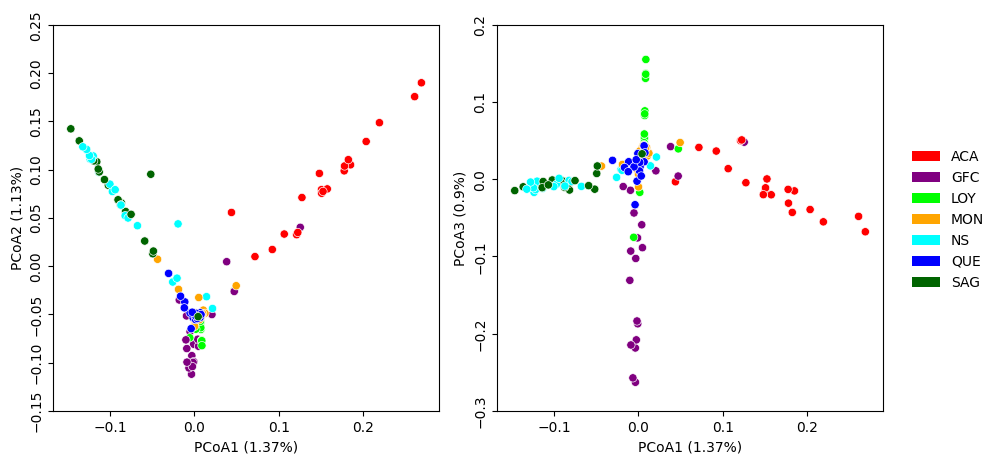

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
left = sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=colors, ax=ax[0],
                     palette={color: color for color in pop_to_color.values()})
left.set_box_aspect(1)
ratio = round(ratios.iloc[0]*100, 2)
left.set_xlabel(f'PCoA1 ({ratio}%)')
ratio = round(ratios.iloc[1]*100, 2)
left.set_ylabel(f'PCoA2 ({ratio}%)')

# Get the current axis
x0, y0, w, h = left.get_position().bounds

# Rotate the y axis labels
yticks = left.get_yticks()
yticklabels = left.get_yticklabels()
left.set_yticks(yticks, yticklabels, va='center', rotation=90)

# Disable legend for the left side
left.get_legend().remove()


right = sns.scatterplot(x=emb[:, 0], y=emb[:, 2], hue=colors, ax=ax[1],
                     palette={color: color for color in pop_to_color.values()})
right.set_box_aspect(1)
ratio = round(ratios.iloc[0]*100, 2)
right.set_xlabel(f'PCoA1 ({ratio}%)')
ratio = round(ratios.iloc[2]*100, 2)
right.set_ylabel(f'PCoA3 ({ratio}%)')

# Get the current axis
x0, y0, w, h = left.get_position().bounds

# Rotate the y axis labels
yticks = right.get_yticks()
yticklabels = right.get_yticklabels()
right.set_yticks(yticks, yticklabels, va='center', rotation=90)


# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop)
                   for pop, color in pop_to_color.items()]

# Add the legend to the plot
right.legend(handles=legend_elements, bbox_to_anchor=(x0 / 2 + w * 3.5, y0 + h / 2),
          loc='right', frameon=False)
fig.tight_layout()
plt.show()

The results are comparable to those of the MDS of figure 2 from the article by Roy-Gagnon et al. (2011) <[https://doi.org/10.1007/s00439-010-0945-x]()>.

Using $-log_2(r_{ij})$ as a distance, it is possible to visualize a finer structure.

In [65]:
dist = -np.log2(corr)
inf_dist = dist.copy()
for i in range(dist.shape[0]):
    for j in range(i):
        if dist.iloc[i, j] == np.inf:
            max_distance = inf_dist.iloc[i, :][inf_dist.iloc[i, :] != np.inf].max()
            dist.iloc[i, j] = max_distance
            dist.iloc[j, i] = max_distance
dist.iloc[:5, :5]

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


,217891,218089,219947,288708,288764
217891,-0.000000,11.055305,6.433998,6.602209,5.951477
218089,11.055305,-0.000000,10.855254,11.090680,11.094540
219947,6.433998,10.855254,-0.000000,6.304220,6.095487
288708,6.602209,11.090680,6.304220,-0.000000,5.961142
288764,5.951477,11.094540,6.095487,5.961142,-0.000000


In [66]:
results = pcoa(dist)
emb = results.samples.to_numpy()
emb[:10, :]

/usr/local/lib/python3.10/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1106.0881296916334 and the largest is 3085.624165786357.
  warn(


array([[ 0.83422042,  0.09808347,  4.44234682, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.6877163 , -3.09857163, -0.49881109, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36460555, -2.72573649,  4.23685909, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.20426379, -3.49063716,  4.51644362, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16656237, -4.67882019,  4.7090195 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34774434, -3.65481332,  3.57369047, ...,  0.        ,
         0.        ,  0.        ]])

In [67]:
ratios = results.proportion_explained
ratios

,0
PC1,0.223433
PC2,0.112658
PC3,0.067238
PC4,0.057828
PC5,0.045985
...,...
PC136,0.000000
PC137,0.000000
PC138,0.000000
PC139,0.000000


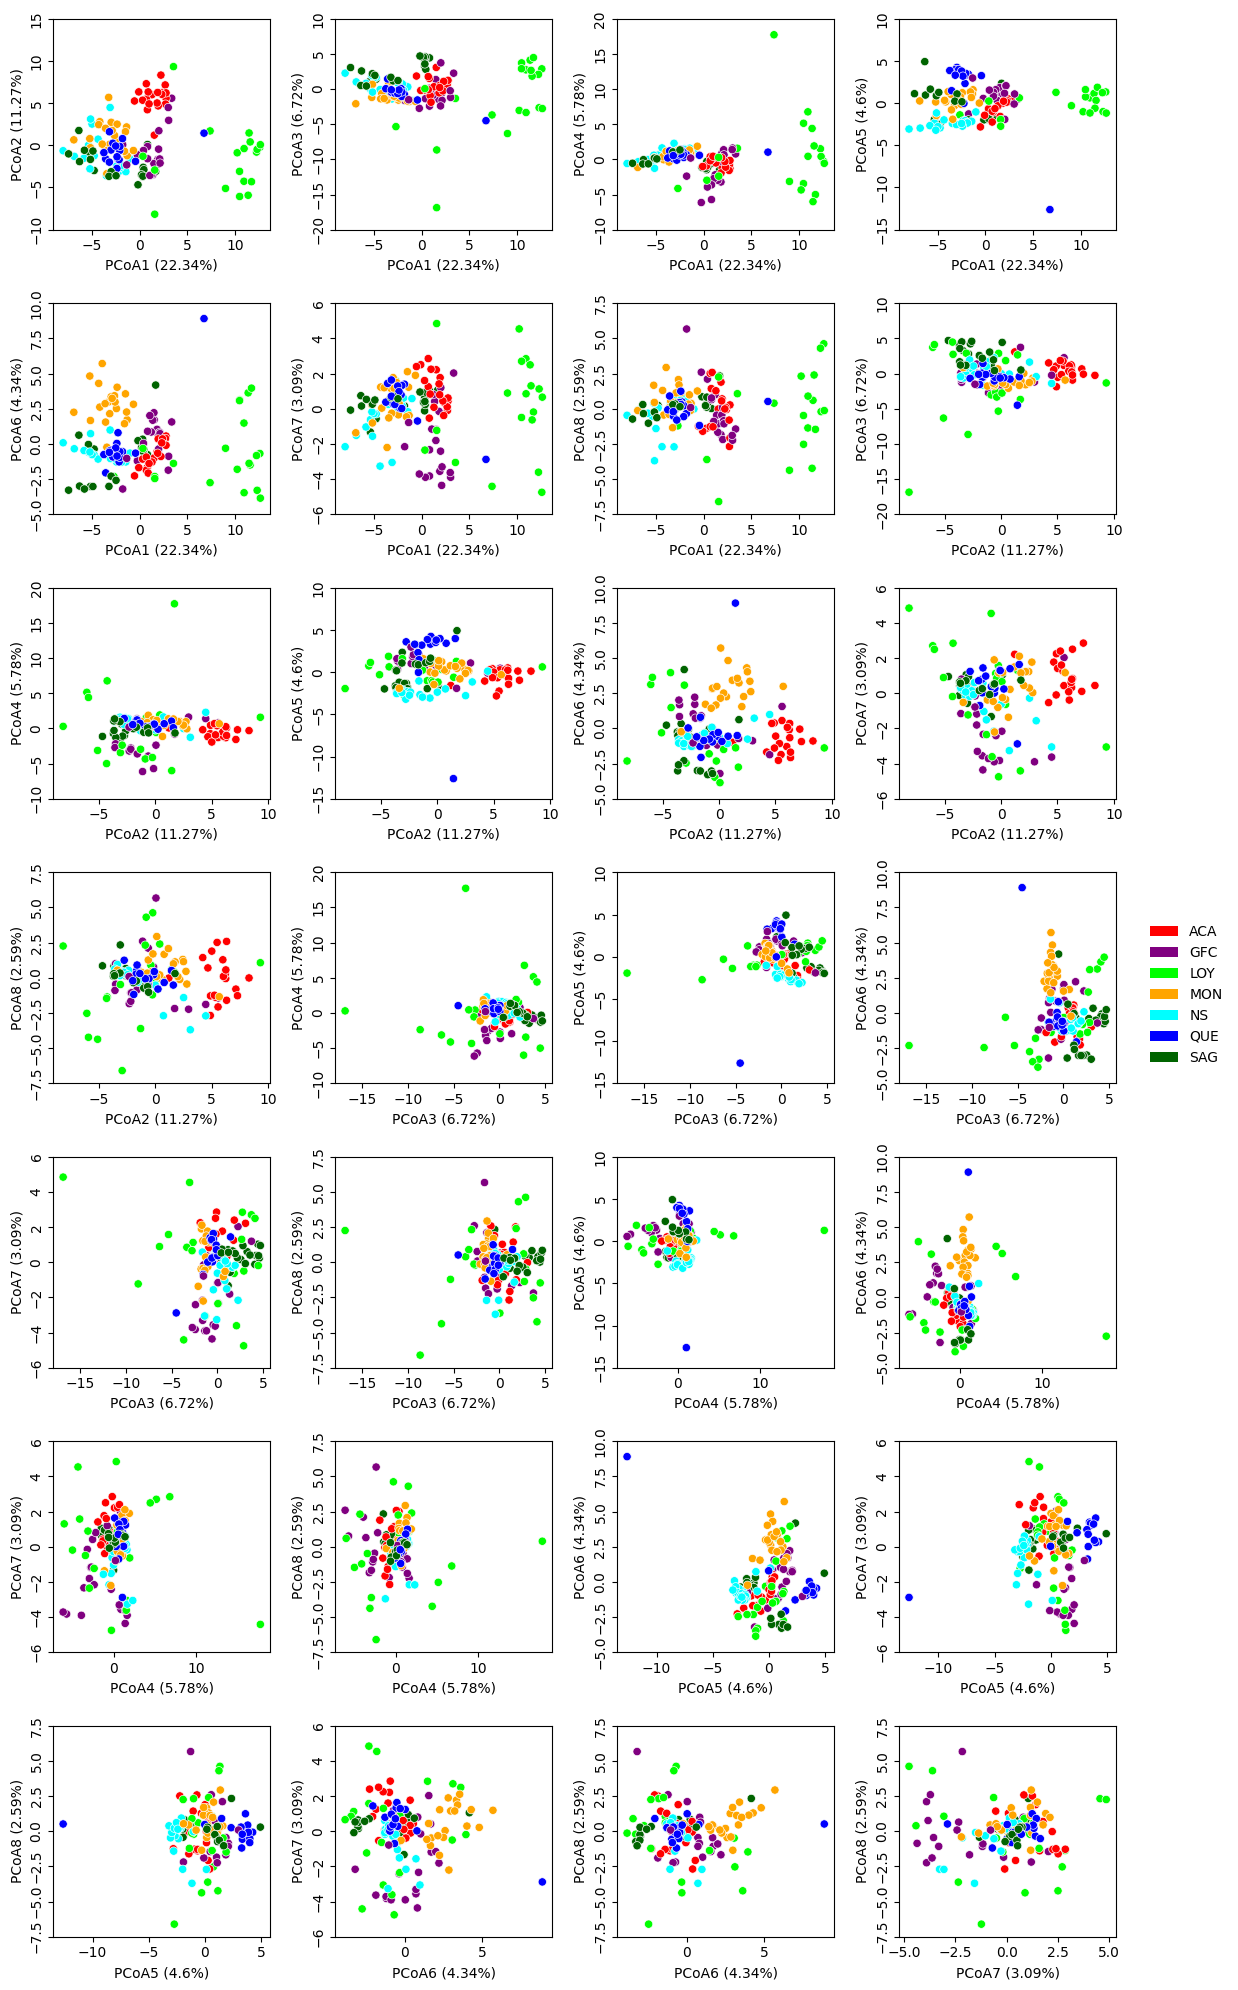

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

comb = list(combinations(range(8), 2))

rows = len(comb) // 4
cols = 4 + len(comb) % 4
fig, axes = plt.subplots(rows, cols, figsize=(cols/rows * 20, 20))

colors = [pop_to_color[population_to_pop[pop]] for pop in pops]

# Loop through combinations and plot
for index, (i, j) in enumerate(comb):
    ax = axes.flat[index]
    sp = sns.scatterplot(
        x=emb[:, i], y=emb[:, j], hue=colors, ax=ax,
        palette={color: color for color in pop_to_color.values()})
    ratio = round(ratios.iloc[i] * 100, 2)
    ax.set_xlabel(f'PCoA{i+1} ({ratio}%)')
    ratio = round(ratios.iloc[j] * 100, 2)
    ax.set_ylabel(f'PCoA{j+1} ({ratio}%)')

    # Rotate the y axis labels
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks, yticklabels, va='center', rotation=90)

    # Disable legend
    sp.get_legend().remove()

# Legend outside the plot
legend_handle = fig.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.5),
                           loc='center left', frameon=False)

plt.tight_layout()
plt.show()

We can see the Acadians in PCoA2, the Gaspesia French Canadians in PCoA7, the Loyalists in PCoA1, the Montrealers in PCoA6, the Quebecers in PCoA5 and the separation of North Shore and Saguenay in PCoA5 and PCoA7. The Quebec outlier is clearly visible in several of the components.